In [1]:
########## Imports ##########
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
import datetime

import packages.fonctions as fonctions
from packages import cost

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

# Modèles
#!pip install catboost
#!brew install cmake libomp
#!pip install lightgbm
from sklearn.dummy import DummyClassifier # modèle baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Feature importance
#!pip install shap
import shap
from sklearn.inspection import permutation_importance

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# MLFLOW
#!pip install mlflow
import mlflow
from mlflow.models import infer_signature
import logging

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

In [2]:
# TERMINAL (pour traquer perfs des différents tests avec mlflow)
# Run a local tracking server

#mlflow server --host 127.0.0.1 --port 8080 # maison mais ne marche pas bureau


In [3]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_train')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.103342   
100003               0.0          0.002089    0.311736     0.152575   
100004               0.0          0.000358    0.022472     0.022985   
100006               0.0          0.000935    0.066837     0.125662   
100007               0.0          0.000819    0.116854     0.090651   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.111337   
100003             0.271605                    0.045016    0.523713   
100004             0.023569                    0.134897    0.652495   
100006             0.063973                    0.107023    0.650181   
100007             0.117845                    0.392880    0.702518   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002           0.964437           0.852140         0.705433     0.098901   
100003           0.933676           0.951929         0.959566     0.098901   
100004           0.987439           0.827335         0.648326     0.285714   
100006           0.830337           0.601451         0.661387     0.098901   
100007           0.830393           0.825268         0.519522     0.098901   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100002             0.0             1.0              0.0               1.0   
100003             0.0             1.0              0.0               1.0   
100004             0.0             1.0              1.0               1.0   
100006             0.0             1.0              0.0               1.0   
100007             0.0             1.0              0.0               1.0   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
100002             1.0         0.0         0.000000                   0.5   
100003             1.0         0.0         0.052632                   0.0   
100004             1.0         0.0         0.000000                   0.5   
100006             0.0         0.0         0.052632                   0.5   
100007             0.0         0.0         0.000000                   0.5   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                              0.5                 0.434783   
100003                              0.0                 0.478261   
100004                              0.5                 0.391304   
100006                              0.5                 0.739130   
100007                              0.5                 0.478261   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                             0.0                         0.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100006                             0.0                         0.0   
100007                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                              0.0                     0.0   
100003                              0.0                     0.0   
100004                              0.0                     0.0   
100006                              0.0                     0.0   
100007             

In [4]:
########## Import des données de la target ##########
filepath = os.path.join(path, 'data/target')

with open(filepath, 'rb') as f:
    df_target = pickle.load(f)

df_target.head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [5]:
# Séparation en train et en test

X = df
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('train shape :', X_train.shape)
print('test shape :', X_test.shape)

print('train shape (target):', y_train.shape)
print('test shape (target):', y_test.shape)

# TO DO
# -> faire varier test_size
# -> fixer le random state pour chaque analyse

train shape : (232842, 175)
test shape : (58211, 175)
train shape (target): (232842,)
test shape (target): (58211,)


In [6]:
######### ML FLOW #########

# EXPLICATIONS A DEVELOPPER

# à faire ici ? ou à mettre dans runs ?
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:8080')
mlflow.set_experiment(experiment_name = 'Scoring implementation')

<Experiment: artifact_location='mlflow-artifacts:/993335670932985653', creation_time=1714995822774, experiment_id='993335670932985653', last_update_time=1714995822774, lifecycle_stage='active', name='Scoring implementation', tags={}>

In [7]:
# ici :
# -> données avec labels -> Supervised Learning
# -> 0/1 (variable discrète) -> Classification

# Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc…
# La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit.
# Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

### Fonction de coût

In [8]:
######### Analyse des erreurs de prédiction ########

# L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN.
# On part du F-Score, mesure de la performance d'un modèle de classification qui combine les mesures de précision et de rappel, elles mêmes basées sur les taux de vrais positifs, faux positifs et faux négatifs
# (donc va être idéal à adapter dans notre cas)

# les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

# - FP (False Positive) :
# = quand la prédiction est positive, mais la valeur réelle est négative
# va induire une perte réelle si le crédit client accepté se transforme en défaut de paiement. -> PENALITE DE 10

# - FN (False Negative) :
# = quand la prédiction est négative, mais la valeur réelle est positive
# va induire une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé. -> PENALITE DE 1

# La fonction de coût personnalisée est définie dans le fichier cost.py (dossier packages).

In [9]:
# En parallèle, maintenir pour comparaison et contrôle des mesures comme l'AUC et l’accuracy

### Modèle Baseline

In [10]:
# Modèle baseline = DummyClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# sert de base pour comparer avec des modèles plus complexes
# fait des prédictions en ignorant les input features
# prets attribués de manière aléatoire

In [11]:
# Entrainement
dc = DummyClassifier()
dc.fit(X_train, y_train)

# Prédictions et évaluations
roc_auc = roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dc.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.00      0.00      0.00      4882

    accuracy                           0.92     58211
   macro avg       0.46      0.50      0.48     58211
weighted avg       0.84      0.92      0.88     58211



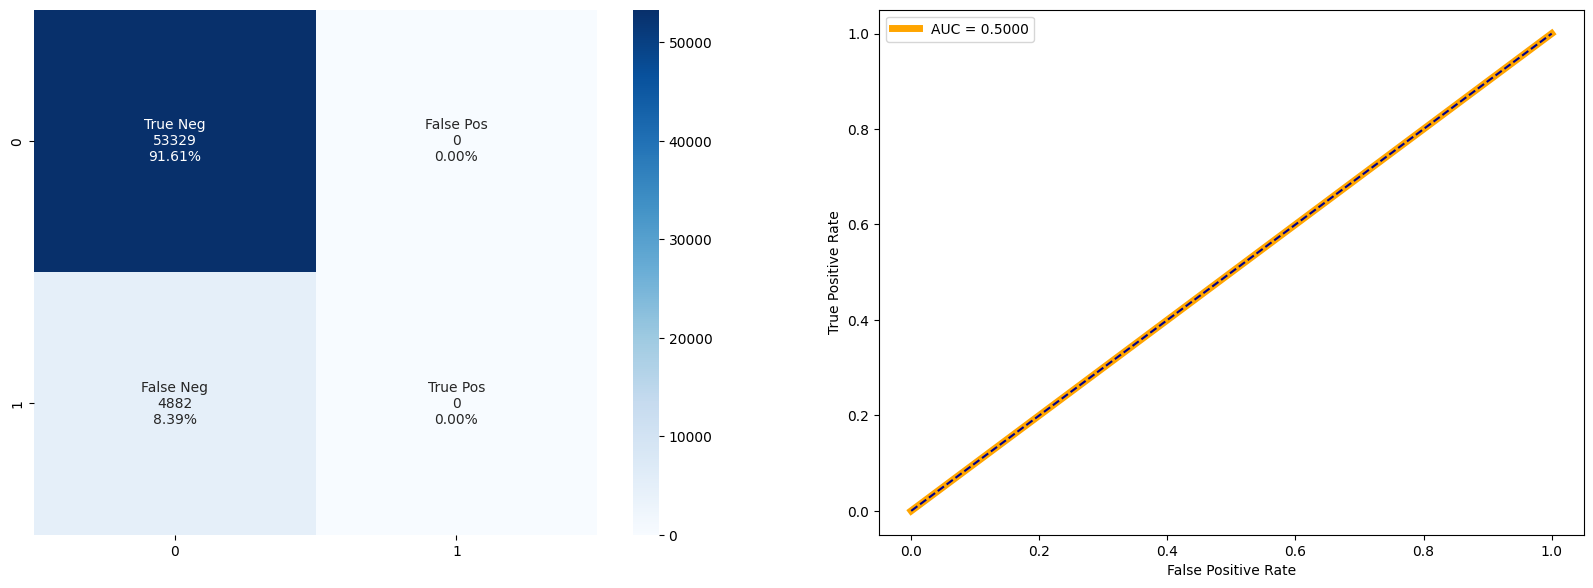

In [12]:
# Visualisation des résultats
fonctions.cf_matrix_roc_auc(dc, y_test, dc.predict(X_test), dc.predict_proba(X_test)[:,1], roc_auc)

In [13]:
# AUC = Area Under the Curve ROC
# courbe ROC : Recall in y-axis and 1-Specificity in x-axis

# -> indicates how well the probabilities from the positive classes are separated from the negative classes
# 0,5 -> 50%/50% -> le marqueur est non informatif
# entre 0,5 et 1,0 -> discrimination

In [14]:
# Evaluation
print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])}')
print(f'Accuracy = {accuracy_score(y_test, dc.predict(X_test))}')
print(f'Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509


In [15]:
print(f'Label 0 : {sum(y_train == 0)}')
print(f'Label 1 : {sum(y_train == 1)}')


Label 0 : 213879
Label 1 : 18963


In [16]:
# Bien plus de 0 que de 1...

####### Déséquilibre des classes #######

# 2 options :
# - undersampling : Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires
# - oversampling : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation

# pour l'oversampling : différentes solutions sont possibles, comme le “clonage” aléatoire ou le SMOTE

In [17]:
# SMOTE
# = Synthetic Minority Oversampling TEchnique
# = méthode de suréchantillonnage des observations minoritaires

# https://kobia.fr/imbalanced-data-smote/

# https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

# PASSER PAR LE PIPELINE IMBLEARN
# si AUC gridsearch dépasse 0,82 -> overfit

# regarder quels modèles peuvent intégrer les class weight

# smote -> faire le split avant le smote (on veut pouvoir valider sur des vraies données - on veut que le modèle ait bon sur de vraies données)
# risque avec smote -> qu'on utilise des données synthétiques dans le jeu de données test quand on cross valide
# https://www.kaggle.com/discussions/questions-and-answers/427399
# sinon risque de data leakage


In [18]:
# Définition de l'instance SMOTE (valeurs par défaut)
sm = SMOTE(
    k_neighbors = 5, # nombre de plus proches voisins
    sampling_strategy = 'auto', # taux d'observations minoritaires à atteindre
    random_state = 0, # default = None mais ici on essaie de prendre le même random state partout afin d'avoir des résultats comparables
    n_jobs = None # nb de cores CPU utilisés pendant la boucle de cross-validation
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [19]:
print(f'Label 0 (après utilisation SMOTE): {sum(y_train_smote == 0)}')
print(f'Label 1 (après utilisation SMOTE): {sum(y_train_smote == 1)}')

# Ici on a inversé le desequilibre...
# besoin de fine tuner smote avant de l'utiliser

Label 0 (après utilisation SMOTE): 213879
Label 1 (après utilisation SMOTE): 213879


In [20]:
###### Tuning SMOTE - k_neighbors ###########

# Compute custom_metric according to k_neighbors
k_value = []

for i in range(2, 20):
    sm = SMOTE(
        k_neighbors = i,
        sampling_strategy = 'auto',
        random_state = 0,
        n_jobs = None
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
    
    k_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)

    # Evaluation
    print(i)
    print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])}')
    print(f'Accuracy = {accuracy_score(y_test, dc.predict(X_test))}')
    print(f'Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

2
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
3
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
4
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
5
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
6
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
7
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
8
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
9
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
10
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
11
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
12
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
13
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
14
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
15
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
16
AUC = 0.5
A

In [21]:
###### Tuning SMOTE - sampling_strategy ###########

# Compute custom_metric according to sampling_strategy
sampling_value = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.75]:
    print(i)

    sm = SMOTE(
        k_neighbors = 5,
        sampling_strategy = i,
        random_state = 0,
        n_jobs = None
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    sampling_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)

    # Evaluation
    print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])}')
    print(f'Accuracy = {accuracy_score(y_test, dc.predict(X_test))}')
    print(f'Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')


0.1
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
0.2
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
0.3
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
0.4
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
0.5
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509
0.75
AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509


In [22]:
# prendre 0.5 ou minority ou all

In [23]:
sm = SMOTE(
    k_neighbors = 5, # nombre de plus proches voisins
    sampling_strategy = 0.5, # taux d'observations minoritaires à atteindre
    random_state = 0,
    n_jobs = None
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [24]:
print(f'Label 0 (après utilisation SMOTE): {sum(y_train_smote == 0)}')
print(f'Label 1 (après utilisation SMOTE): {sum(y_train_smote == 1)}')

Label 0 (après utilisation SMOTE): 213879
Label 1 (après utilisation SMOTE): 106939


In [25]:
# Modèle baseline avec données rééquilibrées
dc_smote = DummyClassifier()
dc_smote.fit(X_train_smote, y_train_smote)

# Prédictions et évaluations
roc_auc = roc_auc_score(y_test, dc_smote.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dc_smote.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.00      0.00      0.00      4882

    accuracy                           0.92     58211
   macro avg       0.46      0.50      0.48     58211
weighted avg       0.84      0.92      0.88     58211



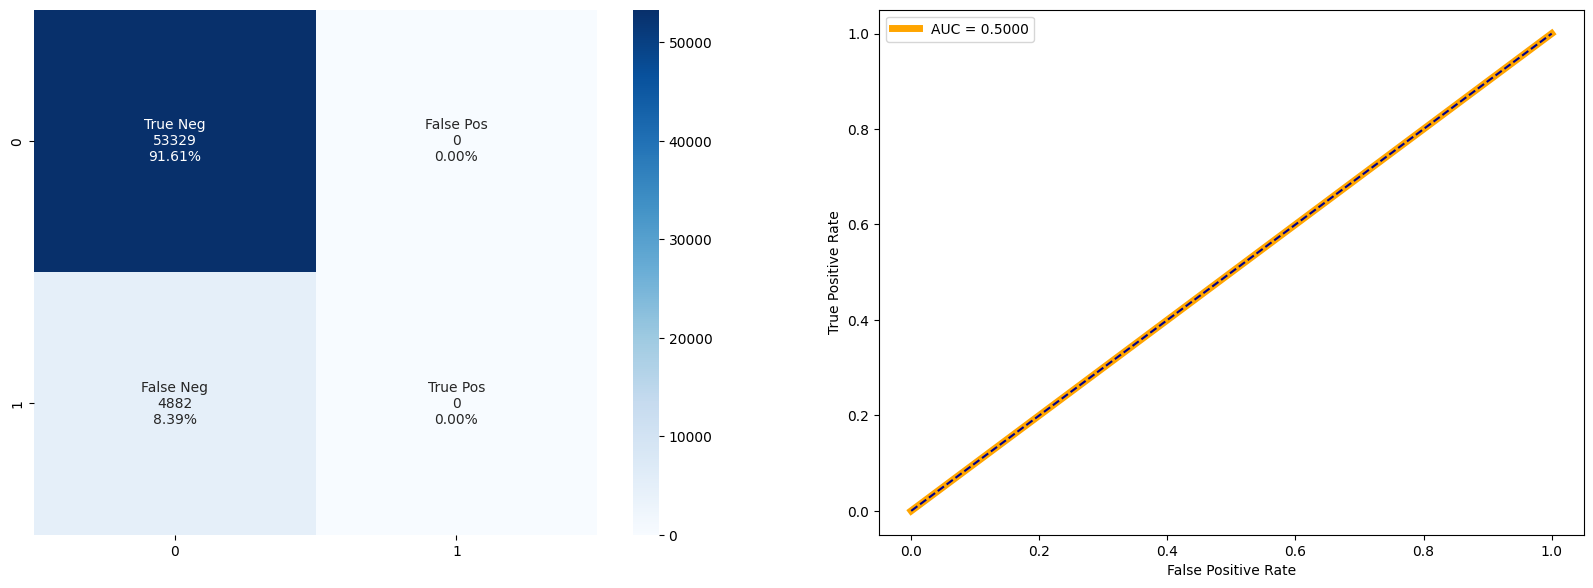

In [26]:
# Visualisation des résultats
fonctions.cf_matrix_roc_auc(dc_smote, y_test, dc_smote.predict(X_test), dc_smote.predict_proba(X_test)[:, 1], roc_auc)

In [27]:
# Evaluation
print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])}')
print(f'Accuracy = {accuracy_score(y_test, dc.predict(X_test))}')
print(f'Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

AUC = 0.5
Accuracy = 0.9161326896978235
Métrique coût custom = 4509


In [28]:
# Tracking du modèle baseline dans ML Flow

# Define the model hyperparameters
params = {
    'strategy': 'most_frequent'
}

# Train the model
dc = DummyClassifier(**params)
dc.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = dc.predict(X_test)

# Calculate metrics
custom = cost.custom_metric(y_test, y_pred)
auc = roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])
accuracy = accuracy_score(y_test, dc.predict(X_test))

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:8080')

# Create a new MLflow Experiment
mlflow.set_experiment('Scoring implementation')

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric('custom', custom)
    mlflow.log_metric('AUC', auc)
    mlflow.log_metric('Accuracy', accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag('Training Info', 'Basic baseline model for loan data')

    # Infer the model signature
    signature = infer_signature(X_train_smote, dc.predict(X_train_smote))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model = dc,
        artifact_path = 'projet7',
        signature = signature,
        input_example = X_train_smote,
        registered_model_name = 'tracking-quickstart',
    )

Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/05/07 15:05:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 9
Created version '9' of model 'tracking-quickstart'.


### Regression logistique

In [29]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Prédictions et évaluations
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7433
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.53      0.01      0.03      4882

    accuracy                           0.92     58211
   macro avg       0.72      0.51      0.49     58211
weighted avg       0.88      0.92      0.88     58211



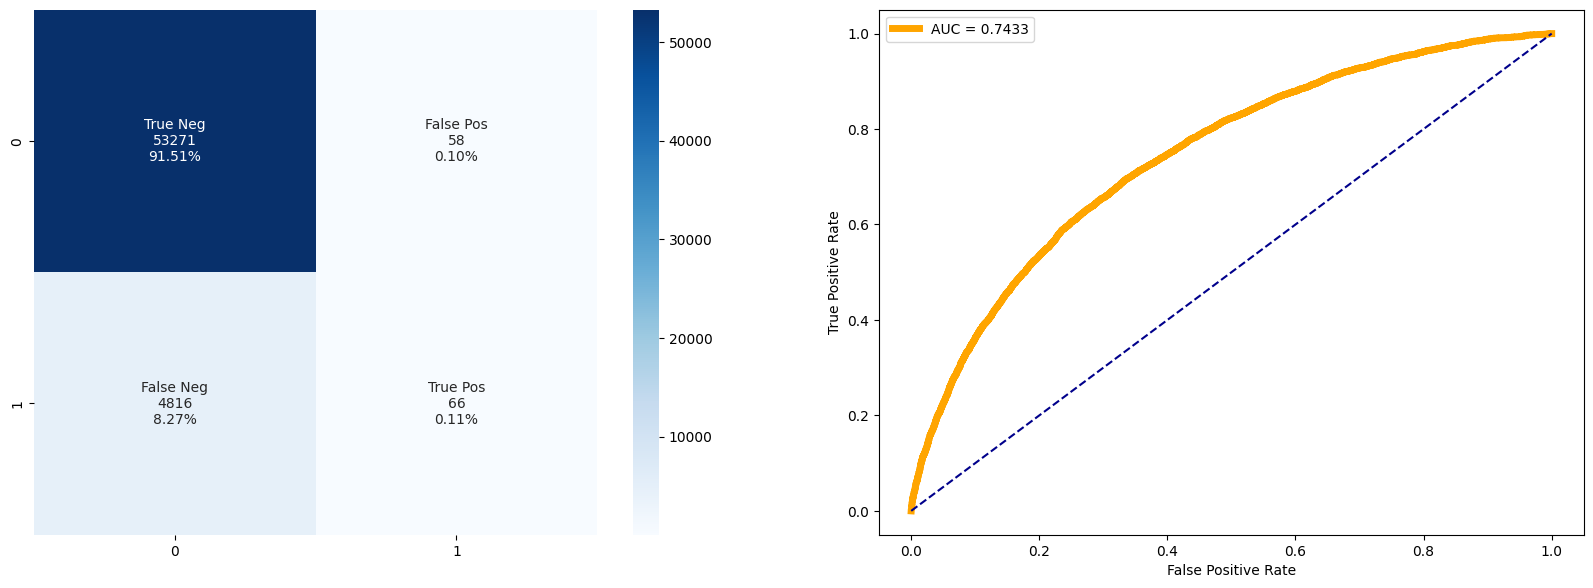

In [30]:
# Visualisation des résultats
fonctions.cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], roc_auc)

In [31]:
# Evaluation
print(f'AUC = {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}')
print(f'Accuracy = {accuracy_score(y_test, lr.predict(X_test))}')
print(f'Métrique coût custom = {cost.custom_metric(y_test, lr.predict(X_test))}')

AUC = 0.7432987750922522
Accuracy = 0.9162701207675525
Métrique coût custom = 5103


In [32]:
######### SMOTE ###########

sm = SMOTE(
    k_neighbors = 5,
    sampling_strategy = 0.5,
    random_state = 0,
    n_jobs = None
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [33]:
# Régression Logistique
lr_smote = LogisticRegression()
lr_smote.fit(X_train_smote, y_train_smote)

# Prédictions et évaluations
roc_auc_smote = roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' %roc_auc_smote)
print(classification_report(y_test, lr_smote.predict(X_test)))

AUC : 0.7412
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     53329
           1       0.23      0.41      0.29      4882

    accuracy                           0.84     58211
   macro avg       0.58      0.64      0.60     58211
weighted avg       0.88      0.84      0.86     58211



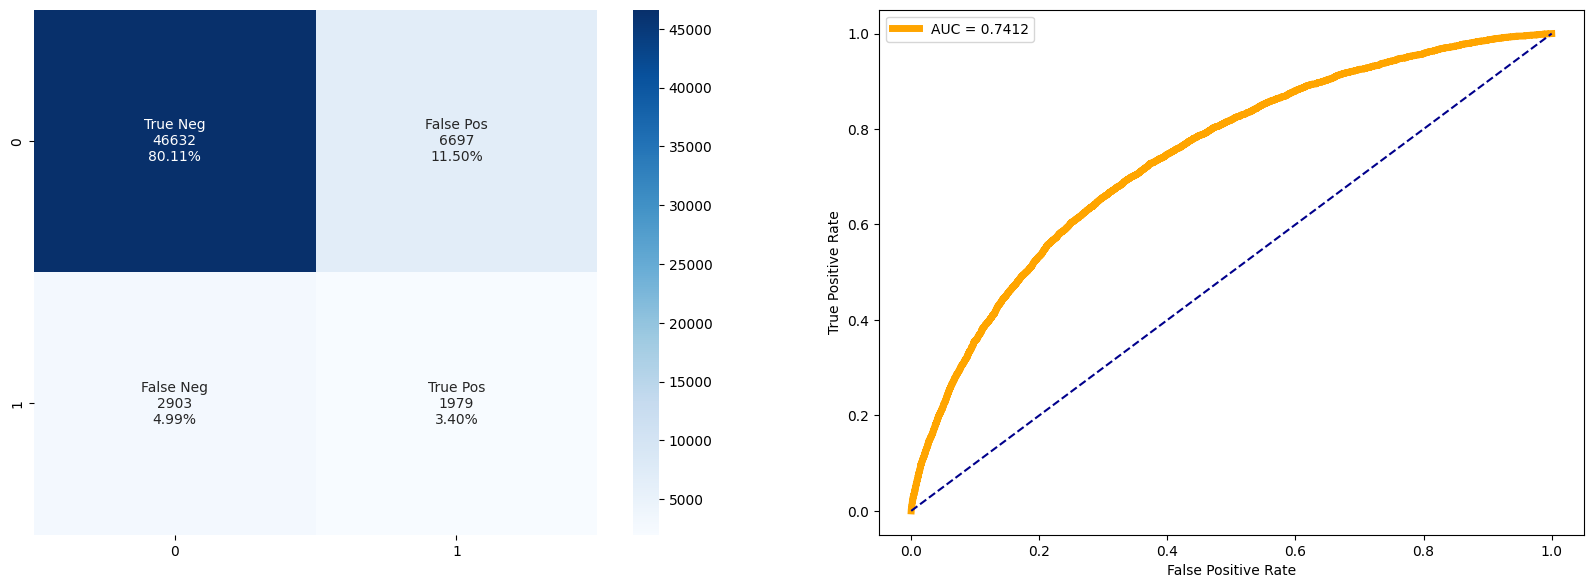

In [34]:
# Visualisation des résultats
fonctions.cf_matrix_roc_auc(lr_smote, y_test, lr_smote.predict(X_test), lr_smote.predict_proba(X_test)[:, 1], roc_auc_smote)

In [35]:
# Evaluation
print(f'AUC = {roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])}')
print(f'Accuracy = {accuracy_score(y_test, lr_smote.predict(X_test))}')
print(f'Métrique coût custom = {cost.custom_metric(y_test, lr_smote.predict(X_test))}')

AUC = 0.7412328004415619
Accuracy = 0.8350827163250932
Métrique coût custom = 22320


In [36]:
# mieux ! test avec d'autres modèles et comparaison

### Test de différents modèles

In [37]:
# Liste des modèles qu'on souhaite tester

models = [
    DummyClassifier(), # modèle baseline
    KNeighborsClassifier(), # k-nearest neighbors
    LogisticRegression(), # Regression logistique
    GaussianNB(), # Naives Bayes
    #SVC(), # -> long !! # Support Vector Machines - beaucoup trop long, exclu d'office
    CatBoostClassifier(logging_level = 'Silent'),
    LGBMClassifier(),
    DecisionTreeClassifier(), # Arbres de decision
    RandomForestClassifier(), # random forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), # gradient boosting
    XGBClassifier() # XGBoost - erreur sur mac perso mais pas pro
    ]

In [38]:
# SVC() -> test sur échantillon réduit et voir si bonnes perfs

In [39]:
# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = fonctions.train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 18963, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27344
[LightGBM] [Info] Number of data points in the train set: 232842, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081441 -> initscore=-2.422921
[LightGBM] [Info] Start training from score -2.422921
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [40]:
base_models

Model       AUC  Accuracy Precision    Recall  \
0           CatBoostClassifier  0.768282   0.91603  0.491713   0.03646   
1               LGBMClassifier  0.763242  0.916356  0.532995  0.021508   
2                XGBClassifier  0.760697  0.915531  0.461707   0.04322   
3   GradientBoostingClassifier  0.754175  0.916201  0.514493  0.014543   
4           AdaBoostClassifier  0.744402  0.916236  0.515306  0.020688   
5           LogisticRegression  0.743299   0.91627  0.532258  0.013519   
6       RandomForestClassifier  0.705259  0.916098  0.428571  0.001229   
7                   GaussianNB  0.643198   0.17349  0.087783  0.942851   
8         KNeighborsClassifier  0.584948  0.910429  0.239812   0.03134   
9       DecisionTreeClassifier  0.539767  0.849376  0.148262  0.167759   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
0   0.067887   6111   40.411383  
1   0.041347   5454    4.222814  
2   0.079041   6408   39.797548  
3   0.028287   5148  318.792617  
4   0.039779   5418   61.800211  
5   0.026368   5103    6.007776  
6   0.002451   4563  154.060701  
7   0.160613  45936      0.8129  
8   0.055435   5886  210.097529  
9   0.157409  11880   35.551249  
10       0.0   4509    0.142377

In [41]:
base_models.sort_values(by = 'Custom', ascending = False)

Model       AUC  Accuracy Precision    Recall  \
7                   GaussianNB  0.643198   0.17349  0.087783  0.942851   
9       DecisionTreeClassifier  0.539767  0.849376  0.148262  0.167759   
2                XGBClassifier  0.760697  0.915531  0.461707   0.04322   
0           CatBoostClassifier  0.768282   0.91603  0.491713   0.03646   
8         KNeighborsClassifier  0.584948  0.910429  0.239812   0.03134   
1               LGBMClassifier  0.763242  0.916356  0.532995  0.021508   
4           AdaBoostClassifier  0.744402  0.916236  0.515306  0.020688   
3   GradientBoostingClassifier  0.754175  0.916201  0.514493  0.014543   
5           LogisticRegression  0.743299   0.91627  0.532258  0.013519   
6       RandomForestClassifier  0.705259  0.916098  0.428571  0.001229   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
7   0.160613  45936      0.8129  
9   0.157409  11880   35.551249  
2   0.079041   6408   39.797548  
0   0.067887   6111   40.411383  
8   0.055435   5886  210.097529  
1   0.041347   5454    4.222814  
4   0.039779   5418   61.800211  
3   0.028287   5148  318.792617  
5   0.026368   5103    6.007776  
6   0.002451   4563  154.060701  
10       0.0   4509    0.142377

In [42]:
# même chose mais avec mlflow et smote

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:8080')
mlflow.set_experiment(experiment_name = 'scoring')

<Experiment: artifact_location='mlflow-artifacts:/758371766557830604', creation_time=1714046714905, experiment_id='758371766557830604', last_update_time=1714046714905, lifecycle_stage='active', name='scoring', tags={}>

In [43]:
with mlflow.start_run(run_name = 'Test modèles'):
    for model in models:
        print(type(model).__name__)
        start = time.time()
        results = fonctions.train_models(model, X_train_smote, X_test, y_train_smote, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        custom.append(results['Custom'])
        time_.append(time.time() - start)

        mlflow.sklearn.log_model(model, 'model')
        mlflow.log_metric('f1 score', results['F1'])
        mlflow.log_metric('custom', results['Custom'])

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 106939, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37448
[LightGBM] [Info] Number of data points in the train set: 320818, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333332 -> initscore=-0.693152
[LightGBM] [Info] Start training from score -0.693152
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [44]:
# FAIRE SVC SUR ECHANTILLONNAGE REDUIT

In [45]:
base_models

Model       AUC  Accuracy Precision    Recall  \
0           CatBoostClassifier  0.764138   0.91603  0.492788  0.041991   
1               LGBMClassifier  0.751928  0.916356  0.535519  0.020074   
2                XGBClassifier  0.750578  0.915325  0.448352  0.041786   
3           LogisticRegression  0.741233  0.835083  0.228101  0.405367   
4   GradientBoostingClassifier  0.711095   0.91603  0.468085  0.009013   
5       RandomForestClassifier  0.690435  0.915222  0.306569  0.008603   
6           AdaBoostClassifier   0.68088   0.89971  0.226857  0.081319   
7         KNeighborsClassifier  0.605942  0.699335  0.123733  0.425031   
8                   GaussianNB  0.553821  0.216059  0.088928  0.902909   
9       DecisionTreeClassifier  0.536893  0.836268  0.135601  0.177181   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
0   0.077388   6354   58.820318  
1   0.038697   5391    6.724951  
2   0.076447   6345   65.681561  
3   0.291931  22320    8.061005  
4   0.017685   4905   557.59086  
5   0.016736   4887  190.801786  
6   0.119723   8082  108.305844  
7   0.191668  23184   329.13006  
8    0.16191  44181    0.930852  
9   0.153628  12294   34.805247  
10       0.0   4509    0.045111

In [46]:
base_models.sort_values('Custom', ascending = False)

Model       AUC  Accuracy Precision    Recall  \
8                   GaussianNB  0.553821  0.216059  0.088928  0.902909   
7         KNeighborsClassifier  0.605942  0.699335  0.123733  0.425031   
3           LogisticRegression  0.741233  0.835083  0.228101  0.405367   
9       DecisionTreeClassifier  0.536893  0.836268  0.135601  0.177181   
6           AdaBoostClassifier   0.68088   0.89971  0.226857  0.081319   
0           CatBoostClassifier  0.764138   0.91603  0.492788  0.041991   
2                XGBClassifier  0.750578  0.915325  0.448352  0.041786   
1               LGBMClassifier  0.751928  0.916356  0.535519  0.020074   
4   GradientBoostingClassifier  0.711095   0.91603  0.468085  0.009013   
5       RandomForestClassifier  0.690435  0.915222  0.306569  0.008603   
10             DummyClassifier       0.5  0.916133       0.0       0.0   

          F1 Custom        Time  
8    0.16191  44181    0.930852  
7   0.191668  23184   329.13006  
3   0.291931  22320    8.061005  
9   0.153628  12294   34.805247  
6   0.119723   8082  108.305844  
0   0.077388   6354   58.820318  
2   0.076447   6345   65.681561  
1   0.038697   5391    6.724951  
4   0.017685   4905   557.59086  
5   0.016736   4887  190.801786  
10       0.0   4509    0.045111

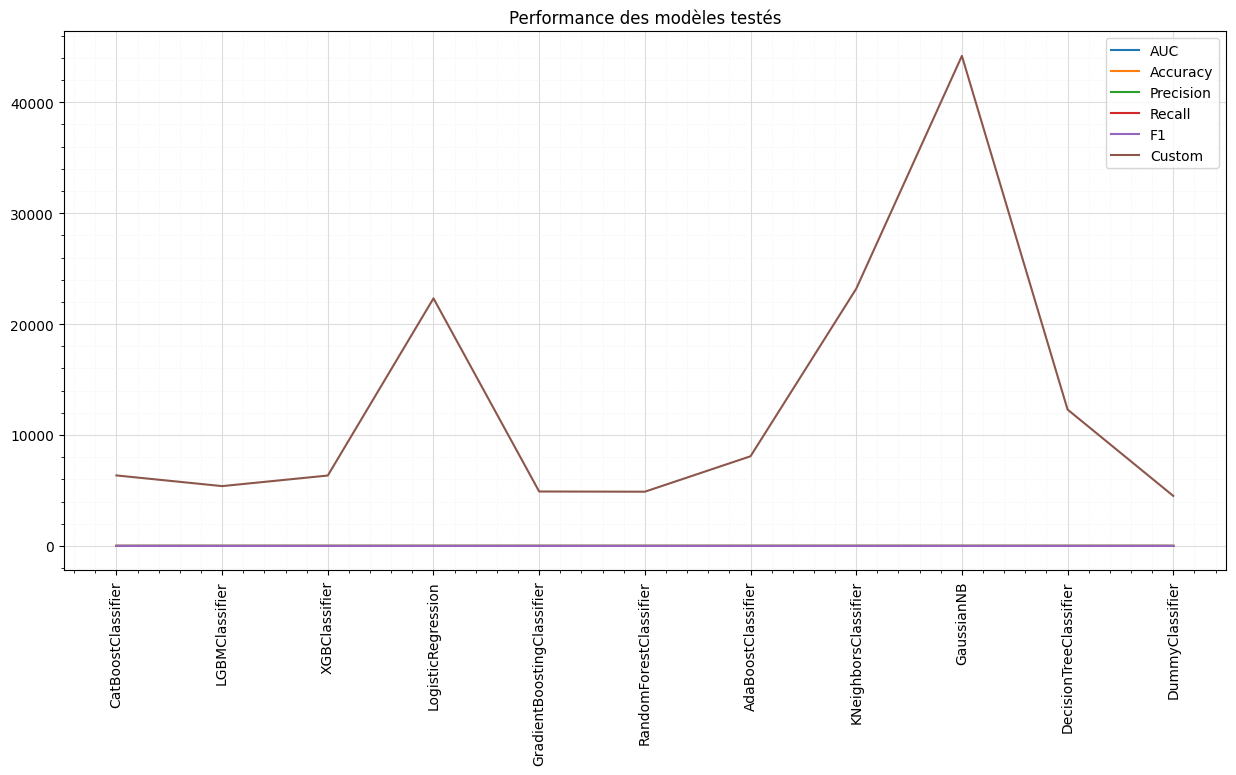

In [47]:
# plot results

plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés')
for i in base_models.drop(['Model', 'Time'], axis = 1).columns:
    plt.plot(base_models['Model'], base_models[i], label = i)
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

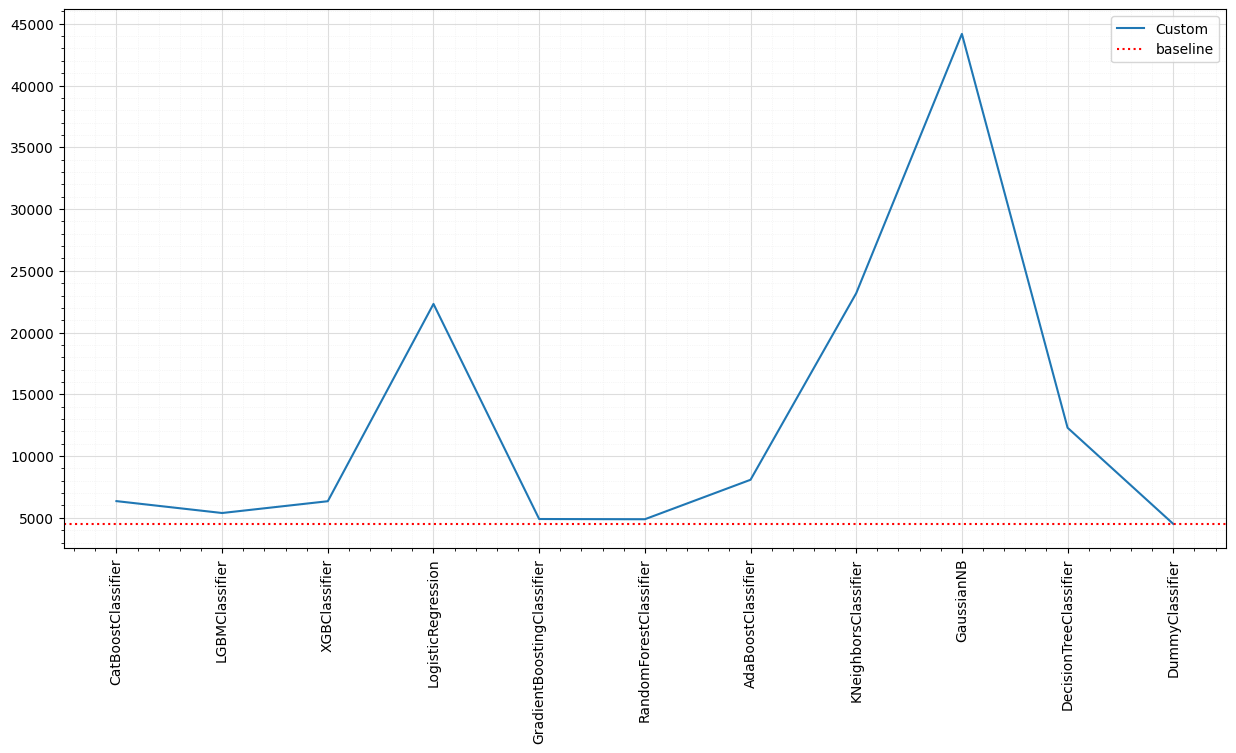

In [48]:
# plot results métrique custom only
base_models_custom = base_models[['Model', 'Custom']]

plt.figure(figsize = (15, 7))
for i in base_models_custom.drop(['Model'], axis = 1).columns:
    plt.plot(base_models_custom['Model'], base_models_custom[i], label = i)
plt.axhline(y = 4509, color = 'r', linestyle = ':', label = 'baseline')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [49]:
# voir comment plotter graphs avec différentes échelles
# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

In [50]:
# Make scorer
# -> permet de définir dans quel "sens" prendre notre nouvelle métrique (ici, plus la valeur est grande, mieux c'est)
custom_score = make_scorer(cost.custom_metric, greater_is_better = True)
custom_score

make_scorer(custom_metric)

In [51]:
########### Fine tunning - GaussianNB ##############

In [52]:
with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    # Instancier le modèle
    gauss = GaussianNB()

    # Entrainer le modèle
    gauss.fit(X_train, y_train)

    # Predire
    y_pred_test_default = gauss.predict(X_test)
    y_pred_train_default = gauss.predict(X_train)

    mlflow.sklearn.log_model(gauss, 'GaussianNB')
    mlflow.log_metric('custom', cost.custom_metric(y_test, gauss.predict(X_test)))
    mlflow.log_metric('AUC', roc_auc_score(y_test, gauss.predict_proba(X_test)[:,1]))
    mlflow.log_metric('Accuracy', accuracy_score(y_test, gauss.predict(X_test)))

XGBClassifier


In [53]:
########## GRIDSEARCH CV ##########

# attention, bien mettre le modèle et __ avant nom du paramètre
param_grid = {
    'classification__var_smoothing': np.logspace(0, -9, num = 100) # stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean
             }

model = Pipeline([('sampling', SMOTE()), ('classification', GaussianNB())])

with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    grid = GridSearchCV(
        model,
        param_grid,
        scoring = custom_score,
        cv = 5,
        verbose = 1,
        n_jobs = -1 # use all CPUs
        )

    # On entraîne la grille
    grid.fit(X_train, y_train)

    # Meilleur score obtenu: best_score_
    print(f'\nBest score = {grid.best_score_}')

    # Optimal hyperparameters: best_params_
    display(grid.best_params_)

    # Sauvegarder le meilleur modèle
    best_gauss = grid.best_estimator_

    # Predire
    y_pred_test_best = best_gauss.predict(X_test)
    y_pred_train_best = best_gauss.predict(X_train)

    mlflow.sklearn.log_model(model, 'GaussianNB grid')
    # Log model configuration/params
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric('custom', cost.custom_metric(y_test, best_gauss.predict(X_test)))
    mlflow.log_metric('AUC', roc_auc_score(y_test, best_gauss.predict_proba(X_test)[:,1]))
    mlflow.log_metric('Accuracy', accuracy_score(y_test, best_gauss.predict(X_test)))


Pipeline
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.


Best score = 35127.6


{'classification__var_smoothing': 1e-09}

Quantités de données à utiliser pour l'entrainement (10 lots): [ 37254  53812  70369  86927 103485 120042 136600 153157 169715 186273]


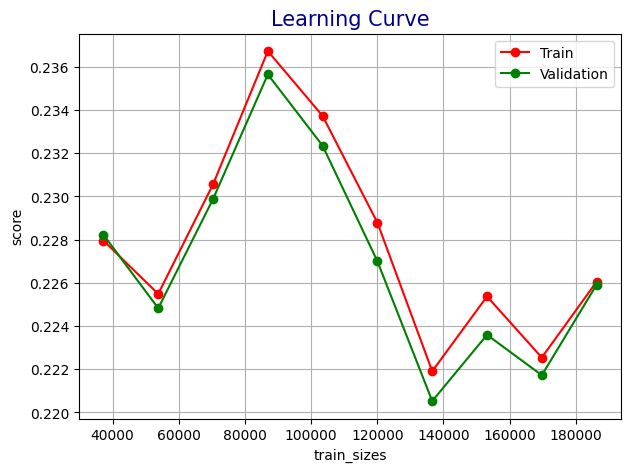

In [54]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_gauss, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
fonctions.plot_learning_curve(N, train_score, val_score)

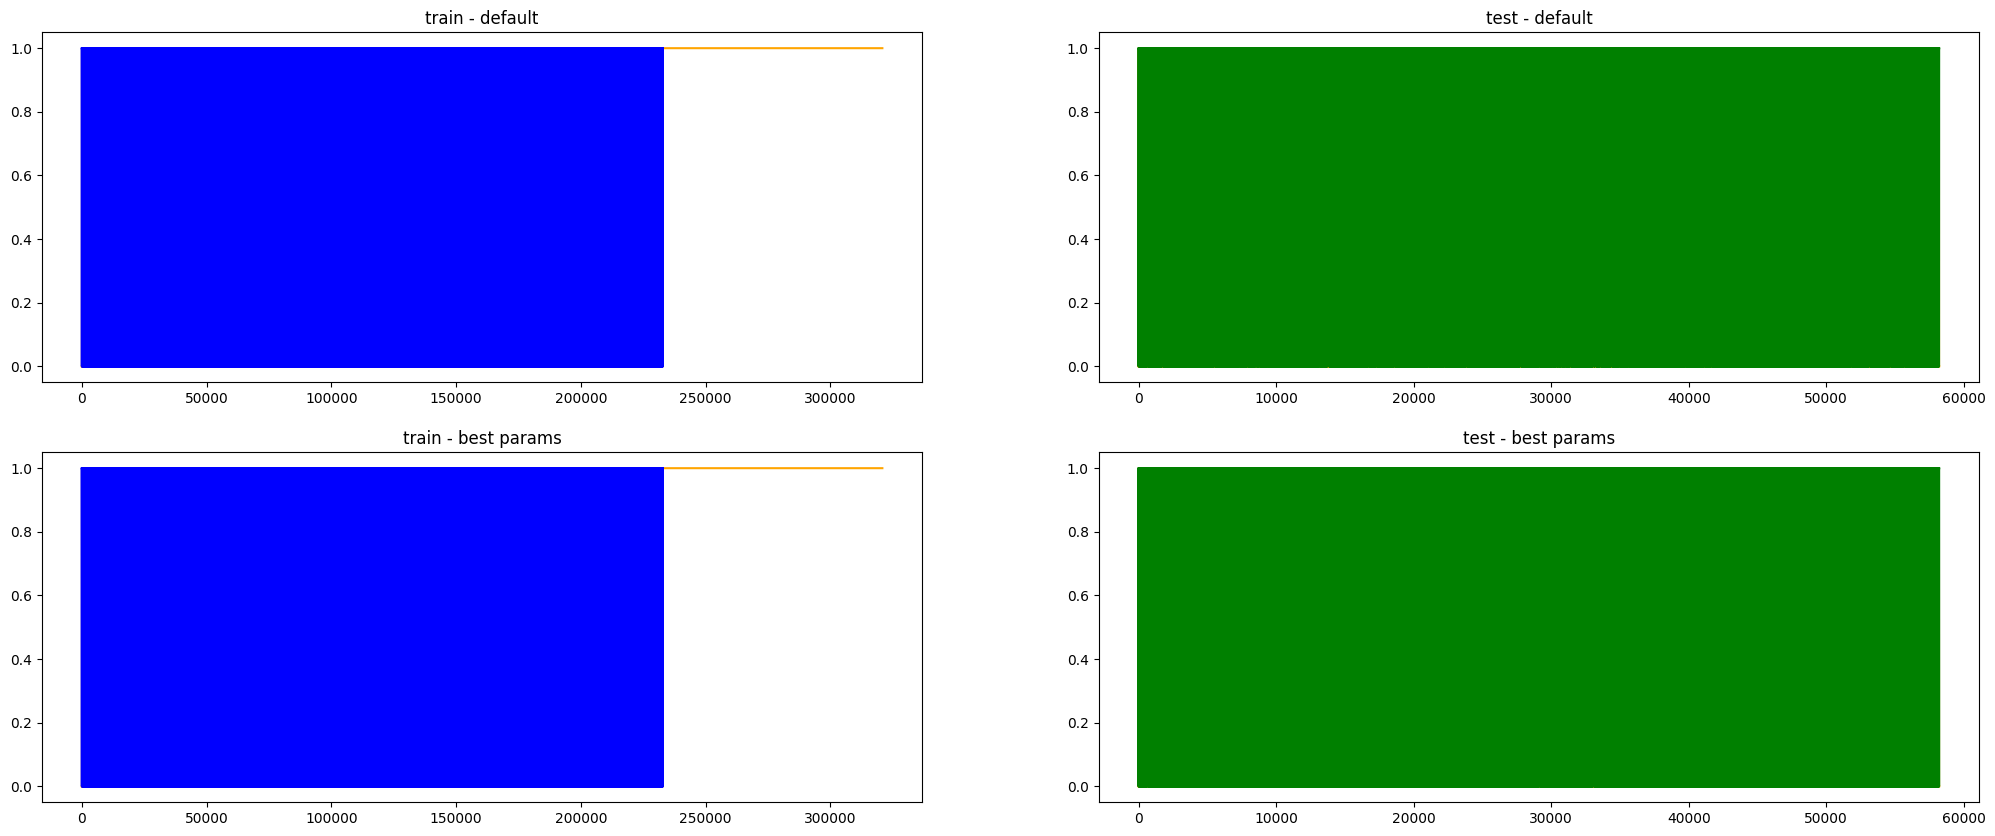

In [55]:
# Plot prédictions
fonctions.plot_predictions(y_train_smote, y_pred_train_default, y_test, y_pred_test_default, y_pred_train_best, y_pred_test_best)

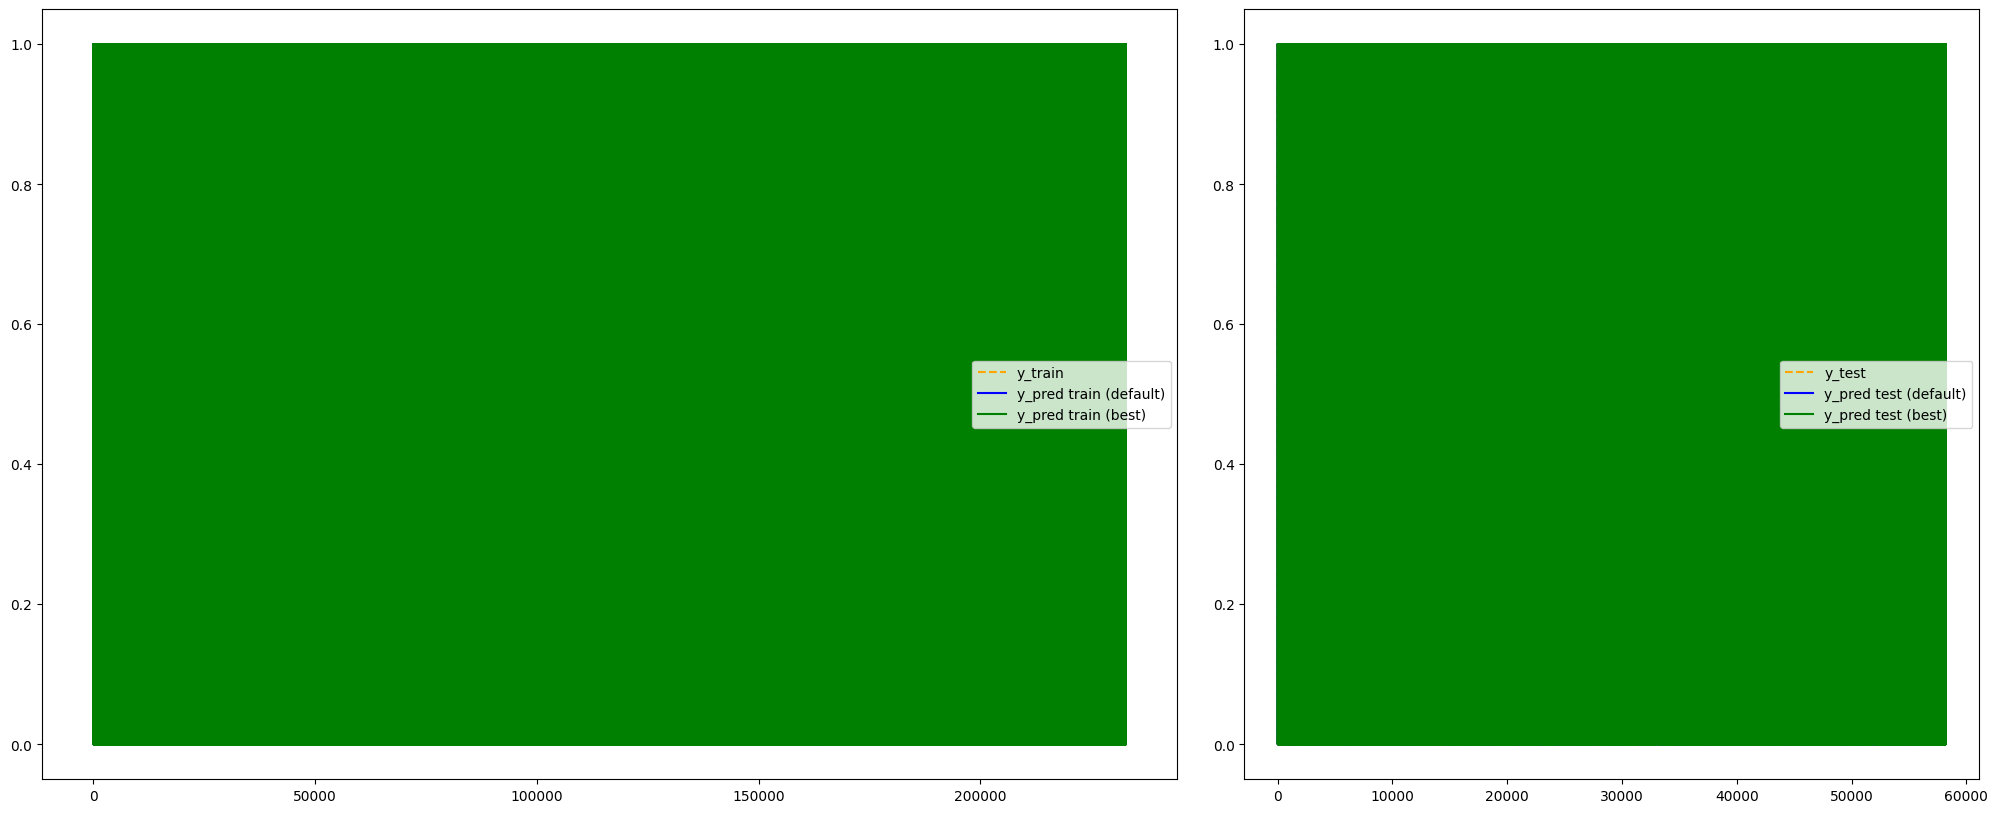

In [56]:
# Plot prédictions
fonctions.plot_predictions_train_test(y_train, y_pred_train_default, y_pred_train_best, y_test, y_pred_test_default, y_pred_test_best)

### Feature importance

In [57]:
# feature importance
# par exemple shap
# certains modèles comme random forest le font direct

# SHAP

# https://www.kaggle.com/code/wrosinski/shap-feature-importance-with-feature-engineering
# https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [58]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

shap.initjs()

In [59]:
best_gauss[1]

GaussianNB()

In [60]:
explainer = shap.Explainer(best_gauss[1])
shap_values = explainer.shap_values(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()

In [ ]:
test_gauss = GaussianNB(var_smoothing=1.0)

explainer = shap.KernelExplainer(test_gauss, X_train)
shap_values = explainer.shap_values(X_test)

Provided model function fails when applied to the provided data set.


TypeError: 'GaussianNB' object is not callable

In [ ]:
# https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes

In [ ]:

imps = permutation_importance(best_gauss, X_test, y_test)
print(imps.importances_mean)

[ 3.43577674e-06 -1.82096167e-04  3.05784130e-04  3.67628112e-04
  3.81371218e-04  2.47375926e-04  6.18439814e-05  6.97462679e-04
 -1.06509079e-04 -4.81008744e-05 -3.33270344e-04  0.00000000e+00
 -1.99275051e-04  1.71788837e-05 -5.15366511e-05 -7.90228651e-05
  6.52797581e-05  3.09219907e-05  1.06509079e-04  1.27123739e-04
 -1.37431070e-05  5.84082046e-05  3.09219907e-05  2.74862139e-05
  2.37068595e-04  1.40866846e-04  1.23687963e-04  1.78660391e-04
  3.95114325e-04  2.16453935e-04 -1.54609953e-04 -5.66903163e-04
  1.71788837e-05  8.89866176e-04 -1.82783323e-03  2.74862139e-04
 -3.09219907e-04  9.82632149e-04  8.00535981e-04 -5.35981172e-04
 -4.98187628e-04 -3.60756558e-04 -1.67322327e-03 -1.34682448e-03
 -6.87155349e-05 -4.84444521e-04  3.77935442e-05  9.10480837e-04
 -1.74537459e-03  2.26761265e-04 -3.19527237e-04  1.01698992e-03
  7.97100204e-04 -5.70338939e-04 -3.98550102e-04 -3.40141898e-04
 -1.56327842e-03 -1.31933827e-03 -1.68353060e-04 -5.25673842e-04
  6.87155349e-06  9.13916

In [ ]:
model.steps

[('sampling', SMOTE()), ('classification', GaussianNB())]

In [ ]:
model.steps[1][1]

GaussianNB()

In [ ]:
########## FEATURES IMPORTANTES ##########
# identifier les features importantes

# get importance
score = model.steps[1][1].feature_importances_
feature = X.columns #(pour ne pas prendre l'index)

# transformer en df pour visualiser plus facilement
df_feature = pd.DataFrame()
df_feature['feature'] = feature
df_feature['score'] = score

df_feature.sort_values(['score'], ascending = False, inplace = True)

# bar plot pour visualiser les 25 features les plus importantes
plt.figure(figsize = (10, 7))
plt.title('Feature importances')
sns.barplot(x = df_feature['feature'].values[:25], y = df_feature['score'].values[:25])
plt.xticks(rotation = 90)
plt.show()

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [ ]:
# Autre solution
# -> decision tree, feature importance et ensuite implémenter sur les features les plus importantes

In [ ]:
########### Fine tunning - DecisionTreeClassifier ##############

In [ ]:
with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    # Instancier le modèle
    tree = DecisionTreeClassifier()

    # Entrainer le modèle
    tree.fit(X_train_smote, y_train_smote)

    # Predire
    y_pred_test_default = tree.predict(X_test)
    y_pred_train_default = tree.predict(X_train_smote)

    mlflow.sklearn.log_model(tree, 'DecisionTreeClassifier')
    mlflow.log_metric('custom', cost.custom_metric(y_test, tree.predict(X_test)))
    mlflow.log_metric('AUC', roc_auc_score(y_test, tree.predict_proba(X_test)[:,1]))
    mlflow.log_metric('Accuracy', accuracy_score(y_test, tree.predict(X_test)))

Pipeline


In [ ]:
########## GRIDSEARCH CV ##########

# attention, bien mettre le modèle et __ avant nom du paramètre
param_grid = {
    'classification__criterion' : ['gini', 'entropy'],
    'classification__max_depth' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }

model = Pipeline([('sampling', SMOTE()), ('classification', DecisionTreeClassifier())])

with mlflow.start_run(run_name = 'Fine tunning'):
    print(type(model).__name__)
    grid = GridSearchCV(
        model,
        param_grid,
        scoring = custom_score,
        cv = 5,
        verbose = 1,
        n_jobs = -1 # use all CPUs
        )

    # On entraîne la grille
    grid.fit(X_train, y_train)

    # Meilleur score obtenu: best_score_
    print(f'\nBest score = {grid.best_score_}')

    # Optimal hyperparameters: best_params_
    display(grid.best_params_)

    # Sauvegarder le meilleur modèle
    best_model = grid.best_estimator_

    # Predire
    y_pred_test_best = best_model.predict(X_test)
    y_pred_train_best = best_model.predict(X_train)

    mlflow.sklearn.log_model(grid, 'DecisionTreeClassifier grid')
    # Log model configuration/params
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric('custom', cost.custom_metric(y_test, best_model.predict(X_test)))
    mlflow.log_metric('AUC', roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
    mlflow.log_metric('Accuracy', accuracy_score(y_test, best_model.predict(X_test)))

Pipeline
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d


Best score = 21400.8


{'classification__criterion': 'entropy', 'classification__max_depth': 5}

Python(82723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Quantités de données à utiliser pour l'entrainement (10 lots): [ 51330  74144  96958 119771 142585 165399 188212 211026 233840 256654]


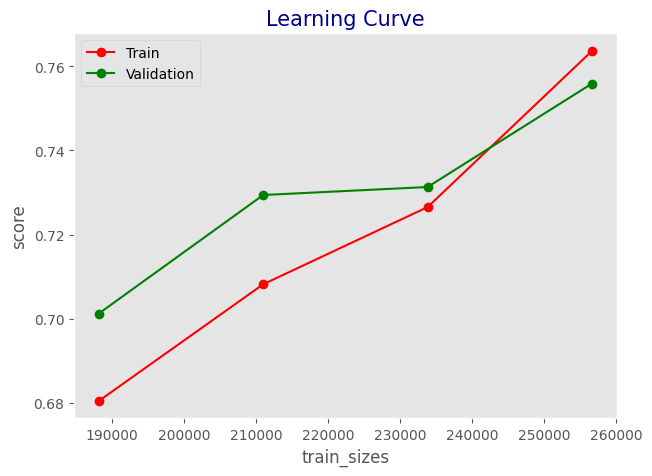

In [ ]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit
N, train_score, val_score = learning_curve(best_model, X_train_smote, y_train_smote, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
fonctions.plot_learning_curve(N, train_score, val_score)

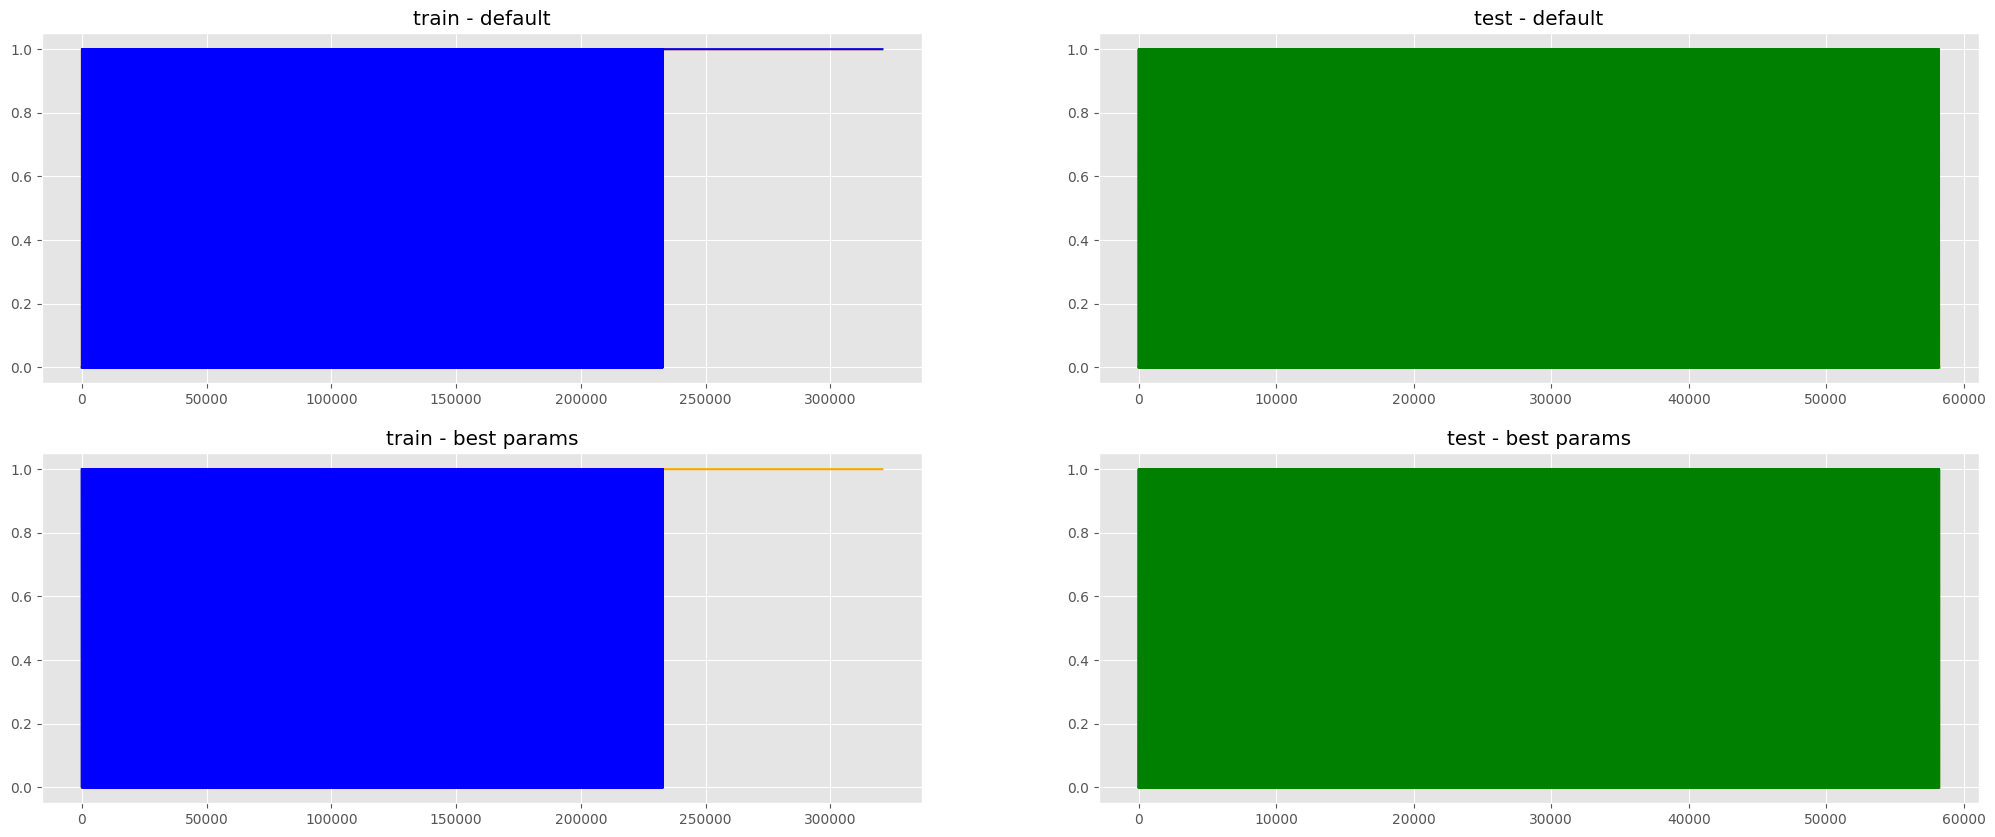

In [ ]:
# Plot prédictions
fonctions.plot_predictions(y_train_smote, y_pred_train_default, y_test, y_pred_test_default, y_pred_train_best, y_pred_test_best)

In [ ]:
# Plot prédictions
fonctions.plot_predictions_train_test(y_train_smote, y_pred_train_default, y_pred_train_best, y_test, y_pred_test_default, y_pred_test_best)

AttributeError: module 'packages.fonctions' has no attribute 'plot_predictions_train_test'

In [ ]:
# identifier les étapes du pipeline
pipeline.steps[1]

# choisir l'étape qu'on veut
pipeline.steps[1][1].feature_importances_

In [ ]:
# à essayer ?
feature_importances = grid.best_estimator_._final_estimator.feature_importances_

NameError: name 'grid' is not defined

In [ ]:
print(grid_search.best_estimator_.named_steps["clf"].feature_importances_)

In [ ]:
print(grid_search.best_estimator_.named_steps["clf"].booster().get_fscore())

In [ ]:
print(grid_search.best_estimator_.named_steps["clf"].get_booster().get_fscore())

In [ ]:
########## FEATURES IMPORTANTES ##########
# identifier les features importantes

# get importance
score = best_model.feature_importances_
feature = X.columns #(pour ne pas prendre l'index)

# transformer en df pour visualiser plus facilement
df_feature = pd.DataFrame()
df_feature['feature'] = feature
df_feature['score'] = score

df_feature.sort_values(['score'], ascending = False, inplace = True)

# bar plot pour visualiser les 25 features les plus importantes
plt.figure(figsize = (10, 7))
plt.title('Feature importances')
sns.barplot(x = df_feature['feature'].values[:25], y = df_feature['score'].values[:25])
plt.xticks(rotation = 90)
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [ ]:
# utiliser mon approche pour "trier" mes features et ne garder que celles qui sont vraiment importantes
# importance global -> s'appuyer sur coef d'importance
# importance "locale" -> utiliser shap
# regarder importance des features et regarder plus localement: pour une prédiction, à quel point chaque feature à joué
# pouvoir expliquer à la fin pourquoi on refuse ou accèpte un crédit (salaire, age...) pour chaque individu

In [ ]:
# implémenter api avant de passer du temps sur le dash (heroku) et déploiement
# modèle "static" -> on l'entraine une fois, on le sauvegarde et on le met derrière une api
# ok si dashboard qui fait appel à l'api tourne en local (peut être plus simple)

In [ ]:
# TO DO
# analyse de data drift
# https://docs.evidentlyai.com/presets/data-drift
# -> sortir un tableau HTML d'analyse de data drift réalisé à partir d'evidently